In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision
from PIL import Image
import matplotlib.pyplot as plt

## 2stage def

In [4]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# Model Definitions
# ----------------------------
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        residual = x
        x = self.relu(self.conv1(x))
        x = self.conv2(x)
        return x + residual

# Base SR Model (first stage)
class SRModel(nn.Module):
    def __init__(self, in_channels=9, out_channels=3, features=64, num_res_blocks=5, upscale_factor=4):
        super(SRModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, features, kernel_size=3, padding=1)
        self.res_blocks = nn.Sequential(*[ResidualBlock(features) for _ in range(num_res_blocks)])
        self.conv2 = nn.Conv2d(features, out_channels * (upscale_factor ** 2), kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.res_blocks(x)
        x = self.conv2(x)
        x = self.pixel_shuffle(x)
        return x

# Refinement Network (second stage)
class RefinementNet(nn.Module):
    def __init__(self, channels=3, features=64, num_res_blocks=3):
        super(RefinementNet, self).__init__()
        self.conv_in = nn.Conv2d(channels, features, kernel_size=3, padding=1)
        self.res_blocks = nn.Sequential(*[ResidualBlock(features) for _ in range(num_res_blocks)])
        self.conv_out = nn.Conv2d(features, channels, kernel_size=3, padding=1)
        
    def forward(self, x):
        out = F.relu(self.conv_in(x))
        out = self.res_blocks(out)
        out = self.conv_out(out)
        # Residual connection: refine rather than re-predict entirely.
        return x + out

# Composite Two-Stage SR Model
class TwoStageSRModel(nn.Module):
    def __init__(self, base_model, refinement_model):
        super(TwoStageSRModel, self).__init__()
        self.base_model = base_model
        self.refinement_model = refinement_model
        
    def forward(self, x):
        base_output = self.base_model(x)
        refined_output = self.refinement_model(base_output)
        return refined_output

# ----------------------------
# Preprocessing and Inference Functions
# ----------------------------
def center_crop(img, target_size):
    """Center crops the image to the target size (width, height)."""
    width, height = img.size
    target_w, target_h = target_size
    left = (width - target_w) // 2
    top = (height - target_h) // 2
    return img.crop((left, top, left + target_w, top + target_h))

# Transformation: convert image to tensor and normalize to [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

def load_lr_frames(lr_dir, target_size=(214, 120)):
    """
    Loads three LR frames (PNG) from the specified directory,
    center-crops them to the target size (width, height),
    applies the transformation, and stacks them into a 9-channel tensor.
    """
    lr_files = sorted([os.path.join(lr_dir, f) for f in os.listdir(lr_dir) if f.endswith(".png")])
    if len(lr_files) < 3:
        raise ValueError("At least 3 LR frames are required in the directory.")
    # Select the first three frames (adjust if needed)
    selected_files = lr_files[:3]
    lr_imgs = []
    for file in selected_files:
        if not os.path.exists(file):
            raise FileNotFoundError(f"LR frame not found: {file}")
        img = Image.open(file).convert("RGB")
        img = center_crop(img, target_size)
        img = transform(img)
        lr_imgs.append(img)
    # Concatenate along channel dimension: 3 frames × 3 channels = 9 channels
    lr_stack = torch.cat(lr_imgs, dim=0)
    return lr_stack.unsqueeze(0)  # Add batch dimension

def infer_hr(lr_tensor, model):
    """
    Runs the model on the LR tensor to produce an HR image.
    The output is denormalized to [0, 1] and converted to a PIL image.
    """
    lr_tensor = lr_tensor.to(device)
    with torch.no_grad():
        hr_output = model(lr_tensor)
    hr_output = (hr_output + 1) / 2  # Denormalize from [-1, 1] to [0, 1]
    hr_output = hr_output.clamp(0, 1)
    return transforms.ToPILImage()(hr_output.squeeze(0).cpu())

def load_model(model_path):
    """
    Instantiates the two-stage SR model and loads the weights from the checkpoint.
    Expects the checkpoint to contain a 'state_dict' key.
    """
    base_model = SRModel(in_channels=9, out_channels=3, features=64, num_res_blocks=5, upscale_factor=4)
    refinement_net = RefinementNet(channels=3, features=64, num_res_blocks=3)
    model = TwoStageSRModel(base_model, refinement_net)
    model.to(device)
    checkpoint = torch.load(model_path, map_location=device)
    state_dict = checkpoint['state_dict']  # Only load model parameters
    model.load_state_dict(state_dict)
    model.eval()
    return model


## 2 stage main

Loading LR frames from: inference/LR/foliage
LR tensor shape: torch.Size([1, 9, 120, 214])
Loading model from: results/2 stage/l1 + vgg/best.pth
Running inference...
HR image saved as: fol_2_vgg_best.png


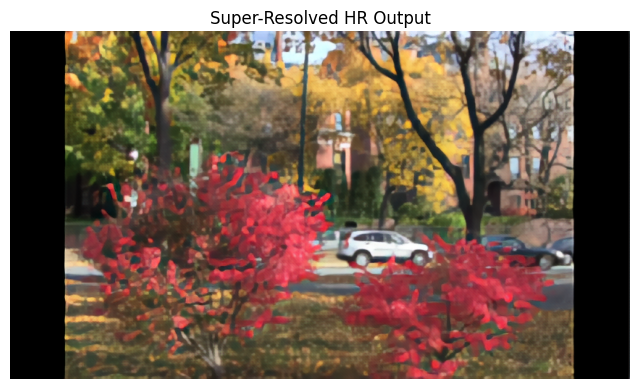

In [27]:
# ----------------------------
# Set your paths here
# ----------------------------
# Replace these with the appropriate paths on your system:
lr_dir = "inference/LR/foliage"        # Directory with at least 3 LR PNG images
model_path = "results/2 stage/l1 + vgg/best.pth"  # Path to your saved checkpoint
output_file = "fol_2_vgg_best.png"     # Output filename for the HR image

# ----------------------------
# Run Inference and Display Results
# ----------------------------
print("Loading LR frames from:", lr_dir)
lr_tensor = load_lr_frames(lr_dir, target_size=(214, 120))
print("LR tensor shape:", lr_tensor.shape)

print("Loading model from:", model_path)
model = load_model(model_path)

print("Running inference...")
hr_img = infer_hr(lr_tensor, model)
hr_img.save(output_file)
print("HR image saved as:", output_file)

# Display the output HR image inline
plt.figure(figsize=(8, 8))
plt.imshow(hr_img)
plt.axis("off")
plt.title("Super-Resolved HR Output")
plt.show()


## 1 stage def

In [13]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# Model Definition: One-Stage SR Model
# ----------------------------
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        residual = x
        x = self.relu(self.conv1(x))
        x = self.conv2(x)
        return x + residual

class OneStageSRModel(nn.Module):
    def __init__(self, in_channels=9, out_channels=3, features=64, num_res_blocks=5, upscale_factor=4):
        super(OneStageSRModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, features, kernel_size=3, padding=1)
        self.res_blocks = nn.Sequential(*[ResidualBlock(features) for _ in range(num_res_blocks)])
        self.conv2 = nn.Conv2d(features, out_channels * (upscale_factor ** 2), kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.res_blocks(x)
        x = self.conv2(x)
        x = self.pixel_shuffle(x)
        return x

# ----------------------------
# Preprocessing and Utility Functions
# ----------------------------
def center_crop(img, target_size):
    """Center-crop PIL image to target_size (width, height)."""
    width, height = img.size
    target_w, target_h = target_size
    left = (width - target_w) // 2
    top = (height - target_h) // 2
    return img.crop((left, top, left + target_w, top + target_h))

# Transformation: convert image to tensor and normalize to [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

def load_lr_frames(lr_dir, target_size=(214, 120)):
    """
    Loads three LR frames (PNG) from the specified directory,
    center-crops them to the target size (width, height),
    applies the transformation, and stacks them into a 9-channel tensor.
    """
    lr_files = sorted([os.path.join(lr_dir, f) for f in os.listdir(lr_dir) if f.endswith(".png")])
    if len(lr_files) < 3:
        raise ValueError("At least 3 LR frames are required in the directory.")
    # Select the first three frames (adjust if needed)
    selected_files = lr_files[:3]
    lr_imgs = []
    for file in selected_files:
        if not os.path.exists(file):
            raise FileNotFoundError(f"LR frame not found: {file}")
        img = Image.open(file).convert("RGB")
        img = center_crop(img, target_size)
        img = transform(img)
        lr_imgs.append(img)
    # Concatenate along channel dimension: 3 frames × 3 channels = 9 channels
    lr_stack = torch.cat(lr_imgs, dim=0)
    return lr_stack.unsqueeze(0)  # Add batch dimension

def infer_hr(lr_tensor, model):
    """
    Runs the model on the LR tensor to produce an HR image.
    Denormalizes output from [-1,1] to [0,1] and returns a PIL image.
    """
    lr_tensor = lr_tensor.to(device)
    with torch.no_grad():
        hr_output = model(lr_tensor)
    hr_output = (hr_output + 1) / 2  # Denormalize
    hr_output = hr_output.clamp(0,1)
    return transforms.ToPILImage()(hr_output.squeeze(0).cpu())

def load_one_stage_model(model_path, features, num_res_blocks):
    """
    Instantiates a one-stage SR model with specified parameters
    and loads weights from the given checkpoint (expects 'state_dict' key).
    """
    model = OneStageSRModel(in_channels=9, out_channels=3, features=features,
                            num_res_blocks=num_res_blocks, upscale_factor=4)
    model.to(device)
    checkpoint = torch.load(model_path, map_location=device)
    state_dict = checkpoint['state_dict']  # Load only model parameters
    model.load_state_dict(state_dict)
    model.eval()
    return model

def bicubic_upscale(lr_tensor, upscale_factor=4):
    """
    Computes bicubic upsampling for a non-AI baseline.
    Extracts the center LR frame (channels 3:6) from the 9-channel input,
    and upsamples it using torch.nn.functional.interpolate.
    """
    center_frame = lr_tensor[:, 3:6, :, :]  # Extract center frame
    with torch.no_grad():
        hr_center = F.interpolate(center_frame, scale_factor=upscale_factor, mode='bicubic', align_corners=False)
    hr_center = (hr_center + 1) / 2  # Denormalize
    hr_center = hr_center.clamp(0,1)
    return transforms.ToPILImage()(hr_center.squeeze(0).cpu())


## 1 stage main

Loading LR frames from: inference/LR/foliage
LR tensor shape: torch.Size([1, 9, 120, 214])
Loading shallow one-stage model...
Shallow model output saved as: fol_1_l1_best.png
Loading deep one-stage model...
Deep model output saved as: fol_1_l1deep_best.png
Computing bicubic interpolation baseline...
Bicubic output saved as: fol_bicubic.png
Composite comparison image saved as: comparison.png


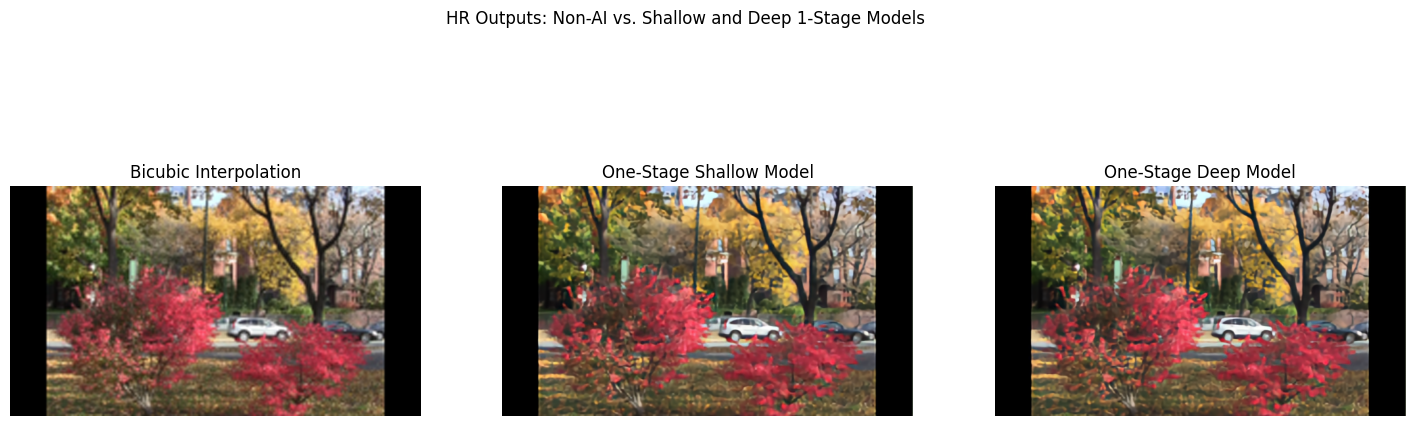

In [28]:



# ----------------------------
# Set your paths and parameters here
# ----------------------------
lr_dir = "inference/LR/foliage"  # Directory containing at least 3 LR PNG images
# Checkpoints for one-stage models (update these paths to your saved checkpoints)
shallow_model_path = "results/channel stacking/l1/best.pth"  # For shallow: features=64, num_res_blocks=5
deep_model_path    = "results/channel stacking/l1 deeper/latest.pth"     # For deep: features=128, num_res_blocks=10

# Output filenames for each method
bicubic_output_file = "fol_bicubic.png"
shallow_output_file = "fol_1_l1_best.png"
deep_output_file = "fol_1_l1deep_best.png"
comparison_output_file = "comparison.png"

# ----------------------------
# Run Inference for All Three Methods
# ----------------------------
print("Loading LR frames from:", lr_dir)
lr_tensor = load_lr_frames(lr_dir, target_size=(214, 120))
print("LR tensor shape:", lr_tensor.shape)

# Shallow one-stage model
print("Loading shallow one-stage model...")
shallow_model = load_one_stage_model(shallow_model_path, features=64, num_res_blocks=5)
hr_shallow = infer_hr(lr_tensor, shallow_model)
hr_shallow.save(shallow_output_file)
print("Shallow model output saved as:", shallow_output_file)

# Deep one-stage model
print("Loading deep one-stage model...")
deep_model = load_one_stage_model(deep_model_path, features=128, num_res_blocks=10)
hr_deep = infer_hr(lr_tensor, deep_model)
hr_deep.save(deep_output_file)
print("Deep model output saved as:", deep_output_file)

# Bicubic interpolation baseline
print("Computing bicubic interpolation baseline...")
hr_bicubic = bicubic_upscale(lr_tensor, upscale_factor=4)
hr_bicubic.save(bicubic_output_file)
print("Bicubic output saved as:", bicubic_output_file)

# ----------------------------
# Create a Composite Comparison Image and Save It
# ----------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(hr_bicubic)
axes[0].set_title("Bicubic Interpolation")
axes[0].axis("off")
axes[1].imshow(hr_shallow)
axes[1].set_title("One-Stage Shallow Model")
axes[1].axis("off")
axes[2].imshow(hr_deep)
axes[2].set_title("One-Stage Deep Model")
axes[2].axis("off")
plt.suptitle("HR Outputs: Non-AI vs. Shallow and Deep 1-Stage Models")
plt.savefig(comparison_output_file, bbox_inches="tight")
print("Composite comparison image saved as:", comparison_output_file)
plt.show()
